<a href="https://colab.research.google.com/github/greeshmamathad/CStudy.io/blob/main/ML_FINAL_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# CS6375: Machine Learning - Final Project
# 
# Stock Market Prediction Using Long Short Term Memory Networks (LSTM)
# 
# Authors: Greeshma Mathad, Sphoorti Kulkarni, Sharan Kumar Satish,
# 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import io
from io import StringIO

In [3]:
def split_dataset (seq, steps, ts_forecast):
  
        X = list()
        y = list()
        
        for idx in seq.index:
            end_ix = idx + steps - 1 
            
            if end_ix + ts_forecast > seq.index[-1]:
                break

            seq_x, seq_y = seq.loc[idx:end_ix], seq[end_ix + ts_forecast]

            X.append(seq_x)
            y.append(seq_y)

        #print(X)
        #print(y)
        
        return np.array(X), np.array(y)

In [4]:
# Calculating the Mean-Square-Error (MSE)
def mse (orig_list, pred_list):

    difference = np.subtract (np.array (orig_list), np.array (pred_list))

    squared_difference = np.square (difference)
    
    mean_square_error = squared_difference.mean()
    #print(mean_square_error)
    
    return mean_square_error

In [5]:
# LSTM Implementation
class LSTM:

    # Constructor for LSTM Class
    def __init__ (self, x_dim,  y_dim, learning_rate,  hidden_neurons, num_cells):

        self.x_dim          = x_dim                   # input dimension
        self.y_dim          = y_dim                   # output dimension
        self.learning_rate  = learning_rate           # learning rate
        self.hidden_neurons = hidden_neurons          # hidden neurons amount
        self.num_cells      = num_cells               # lstm cells amount

        self.final_weights = np.random.random((y_dim, hidden_neurons))     # final output weights
        self.final_bias    = np.random.random((y_dim, 1))                  # final output bias

        self.forget_state_list  =  [np.zeros((hidden_neurons,1)) for counter in range(num_cells)]  # forget states storage
        self.cell_state_list    =  [np.zeros((hidden_neurons,1)) for counter in range(num_cells)]  # cell states storage
        self.hidden_states_list =  [np.zeros((hidden_neurons,1)) for counter in range(num_cells)]  # hidden states storage
        self.output_list        =  [np.zeros((hidden_neurons,1)) for counter in range(num_cells)]  # outputs storage
        self.input_list         =  [np.zeros((hidden_neurons,1)) for counter in range(num_cells)]  # inputs storage
        self.cell_cand_list     =  [np.zeros((hidden_neurons,1)) for counter in range(num_cells)]  # cell candidates states storage

        self.forget_weights = np.random.random((hidden_neurons, x_dim+hidden_neurons)) / np.sqrt(x_dim+self.hidden_neurons) # forget gate weights
        self.cell_weights   = np.random.random((hidden_neurons, x_dim+hidden_neurons)) / np.sqrt(x_dim+self.hidden_neurons) # cell state gate weights
        self.output_weights = np.random.random((hidden_neurons, x_dim+hidden_neurons)) / np.sqrt(x_dim+self.hidden_neurons) # output gate weights
        self.input_weights  = np.random.random((hidden_neurons, x_dim+hidden_neurons)) / np.sqrt(x_dim+self.hidden_neurons) # input gate weights

        self.forget_bias = np.random.random((hidden_neurons, 1)) # forget gate bias
        self.cell_bias   = np.random.random((hidden_neurons, 1)) # cell state gate bias

        self.output_bias = np.random.random((hidden_neurons, 1)) # output gate bias
        self.input_bias  = np.random.random((hidden_neurons, 1)) # input gate bias

    # Function to calculate the predicted values given x
    def forward (self, x):

        x = np.array(x)
        self.x = x

        for t in range(1, self.num_cells):

            f = self.sigmoid(self.forget_weights @ np.vstack((self.hidden_states_list[t-1], self.x[t])) + self.forget_bias) 
            i = self.sigmoid(self.input_weights @ np.vstack((self.hidden_states_list[t-1], self.x[t])) + self.input_bias) 
            cell_cand = self.tanh(self.cell_weights @ np.vstack((self.hidden_states_list[t-1], self.x[t])) + self.cell_bias) 
            c = f * self.cell_state_list[t-1] + i * cell_cand
            o = self.sigmoid(self.output_weights @ np.vstack((self.hidden_states_list[t-1], self.x[t])) + self.output_bias)
            h = o * self.tanh(c)

            # storing values to use in the next iteration
            self.forget_state_list[t] = f
            self.input_list[t] = i   
            self.cell_cand_list[t] = cell_cand   
            self.cell_state_list[t] = c      
            self.output_list[t] = o                                    
            self.hidden_states_list[t] = h

        y_pred = self.final_weights @ self.hidden_states_list[-1] + self.final_bias
        # print (y_pred)

        return y_pred

    #Given the expected and predicted outputs, calculate the delta values using backpropatation through time
    def backpropagate (self,y_expected, y_pred):

        d_hidden_list     = [np.zeros((self.hidden_neurons,1)) for counter in range(self.num_cells+1)]
        d_output_list     = [np.zeros((self.hidden_neurons,1)) for counter in range(self.num_cells+1)]
        d_cell_state_list = [np.zeros((self.hidden_neurons,1)) for counter in range(self.num_cells+1)]
        d_forget_list     = [np.zeros((self.hidden_neurons,1)) for counter in range(self.num_cells+1)]
        d_input_list      = [np.zeros((self.hidden_neurons,1)) for counter in range(self.num_cells+1)]
        d_cell_cand_list  = [np.zeros((self.hidden_neurons,1)) for counter in range(self.num_cells+1)]

        d_final_weights = np.zeros_like(self.final_weights)
        d_final_bias    = np.zeros_like(self.final_bias)

        d_forget_weights = np.zeros_like(self.forget_weights)
        d_forget_bias    = np.zeros_like(self.forget_bias)

        d_cell_weights  = np.zeros_like(self.cell_weights)
        d_cell_bias     = np.zeros_like(self.cell_bias)

        d_input_weights = np.zeros_like(self.input_weights)
        d_input_bias    = np.zeros_like(self.input_bias)

        d_output_weights = np.zeros_like(self.output_weights)
        d_output_bias    = np.zeros_like(self.output_bias)

        delta_e = y_expected - y_pred

        d_final_weights = delta_e * self.hidden_states_list[-1].T
        d_final_bias    = delta_e

        #print(d_final_weights)
        #print(d_final_bias)

        for t in reversed (range(self.num_cells)):
            d_hidden_list[t]  = self.final_weights.T @ delta_e + d_hidden_list[t+1]
            d_output_list[t] = self.tanh(self.cell_state_list[t])*d_hidden_list[t] * self.prime_sigmoid(self.hidden_states_list[t])
            d_cell_state_list[t] = self.output_list[t]*d_hidden_list[t]*self.prime_tanh(self.cell_state_list[t]) + d_cell_state_list[t+1]
            d_forget_list[t] = self.cell_state_list[t-1]*d_cell_state_list[t]*self.prime_sigmoid(self.forget_state_list[t])
            d_input_list[t] = self.cell_cand_list[t]*d_cell_state_list[t]*self.prime_sigmoid(self.input_list[t])
            d_cell_cand_list[t] = self.input_list[t]*d_cell_state_list[t]*self.prime_tanh(self.cell_cand_list[t])

            z = np.vstack((self.hidden_states_list[t-1], self.x[t]))
            #print(z)

            d_forget_weights += d_forget_list[t] @ z.T
            d_forget_bias += d_forget_list[t]

            # print (d_forget_weights)
            # print (d_forget_bias)
            
            d_input_weights += d_input_list[t] @ z.T
            d_input_bias += d_input_list[t]

            d_output_weights += d_output_list[t] @ z.T
            d_output_bias += d_output_list[t]

            #print (d_output_weights)
            #print (d_output_bias)

            d_cell_weights += d_cell_state_list[t] @ z.T
            d_cell_bias += d_cell_state_list[t]

        return d_final_weights, d_final_bias, d_forget_weights/self.num_cells, d_forget_bias/self.num_cells, d_input_weights/self.num_cells, d_input_bias/self.num_cells, d_output_weights/self.num_cells, d_output_bias/self.num_cells, d_cell_weights/self.num_cells, d_cell_bias/self.num_cells

    # FUnction to train the model
    def fit (self, iterations, x, y_expected, x_validation=None, y_expected_validation=None):
        # training loss function list
        print("Training the model on the data...")
        training_loss_list = list()
        # validation loss function list
        validation_loss_list = list()

        for counter in range (iterations):
            loss_training = 0
            loss_validation = 0

            for i in range (len(x)):
                y_prediction = self.forward(x[i])
                #print (y_prediction)

                d_final_weights, d_final_bias, d_forget_weights, d_forget_bias, d_input_weights, d_input_bias, d_output_weights, d_output_bias, d_cell_weights, d_cell_bias = self.backpropagate(y_expected[i], y_prediction)

                self.final_weights = self.final_weights + self.learning_rate*d_final_weights
                self.final_bias = self.final_bias + self.learning_rate*d_final_bias

                self.forget_weights = self.forget_weights + self.learning_rate*d_forget_weights
                self.forget_bias = self.forget_bias + self.learning_rate*d_forget_bias

                self.input_weights = self.input_weights + self.learning_rate*d_input_weights
                self.input_bias = self.input_bias + self.learning_rate*d_input_bias

                self.output_weights = self.output_weights + self.learning_rate*d_output_weights
                self.output_bias = self.output_bias + self.learning_rate*d_output_bias

                self.cell_weights = self.cell_weights + self.learning_rate*d_cell_weights
                self.cell_bias = self.cell_bias + self.learning_rate*d_cell_bias

                loss_training += ((y_expected[i] - y_prediction)**2)/2
                #print("Training loss: ", loss_training)

            training_loss_list.append(loss_training)
            #print("training_loss_list")

            if y_expected_validation is not None and x_validation is not None:
              y_prediction_validation = self.predict(x_validation)
              y_prediction_validation = y_prediction_validation.reshape((y_prediction_validation.shape[0], 1))
              y_expected_validation = y_expected_validation.reshape((y_expected_validation.shape[0], 1))

              loss_validation = np.sum( (y_expected_validation - y_prediction_validation)**2 , axis =0)/2
              validation_loss_list.append(loss_validation)
            #print("Training loss, Validation loss: ", loss_training, loss_validation)

        print("Training completed.")

        if x_validation is not None and y_expected_validation is not None:
          return np.concatenate(training_loss_list), np.concatenate(validation_loss_list)
      
    def predict (self, x):
        y_prediction = list()

        for i in range (len(x)):
            y_prediction.append ( self.forward(x[i]) )

        print("Predicted Y:",y_prediction[-1]) 

        return np.concatenate(y_prediction)

    #Sigmoid function
    def sigmoid (self, z):
        #print (1+np.exp(-z))
        return 1 / (1+np.exp(-z))

    #Sigmod prime function
    def prime_sigmoid (self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    #Tanh function
    def tanh (self, z):
        #print(np.tanh(z))
        return np.tanh(z)

    #Tanh prime function
    def prime_tanh (self, z):
        t = (z ** 2)
        return 1 - t
                                          

In [6]:
# Normalize dataset
def normalize_data (true_values):
    min_val = min(true_values)
    max_val = max(true_values)
    range_val = max_val - min_val
    scaled_vals = []
    for val in true_values:
        norm_val = (val-min_val)/range_val
        scaled_vals.append(norm_val)
    return scaled_vals

In [7]:
# Reading the dataset
full_data = pd.read_csv("https://raw.githubusercontent.com/praneeha/ML/main/crypto_6years.csv").iloc[::-1].tail(305)
time_series_vals = pd.DataFrame(full_data['Price']).reset_index()['Price']
true_time_series = pd.Series([float(x.replace(',','')) for x in time_series_vals])

In [8]:
# Normalize the dataset
def normalize_data(true_values):

    min_val = min(true_values)
    max_val = max(true_values)
    range_val = max_val - min_val
    scaled_vals = []

    for val in true_values:
        norm_val = (val - min_val) / range_val
        scaled_vals.append(norm_val)

    return scaled_vals

In [9]:
time_series = pd.Series(normalize_data(true_time_series))

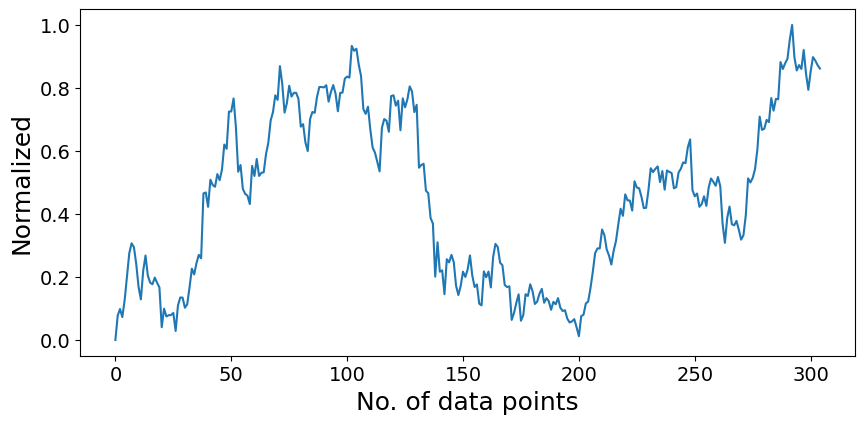

In [10]:
plt.figure(figsize=(10, 4.5))

plt.plot(time_series)

plt.ylabel('Normalized', fontsize=18)
plt.xlabel('No. of data points', fontsize=18)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.show()

In [11]:
# Train test data split
series_train_tmp, series_test = train_test_split(time_series, test_size=0.2, shuffle=False)
series_train, series_validation = train_test_split(series_train_tmp, test_size=0.2, shuffle=False)

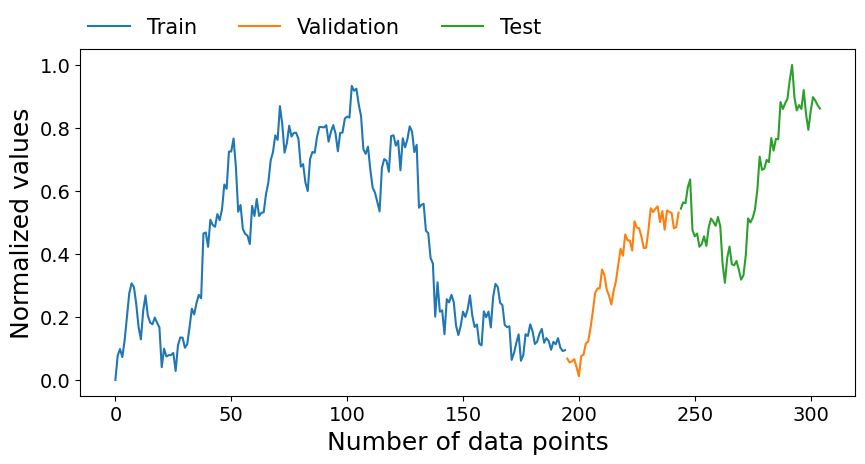

In [12]:
plt.figure(figsize=(10, 4.5))

plt.plot(series_train, label = 'Train')
plt.plot(series_validation, label = 'Validation')
plt.plot(series_test, label = 'Test')

plt.xlabel('Number of data points', fontsize=18)
plt.ylabel('Normalized values', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=3, 
           borderaxespad=0, frameon=False, prop={"size":15})
plt.show()

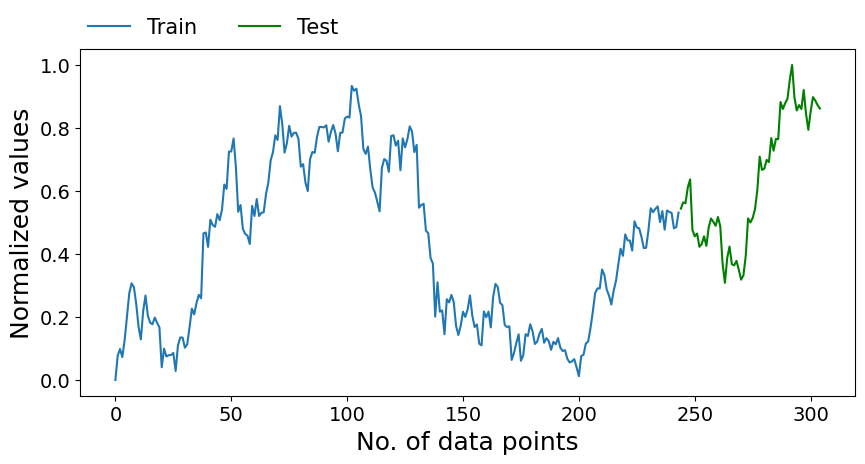

In [13]:
plt.figure(figsize=(10, 4.5))

plt.plot(series_train_tmp, label = 'Train')
plt.plot(series_test, label = 'Test', color='green')

plt.xlabel('No. of data points', fontsize=18)
plt.ylabel('Normalized values', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2, 
           borderaxespad=0, frameon=False, prop={"size":15})
plt.show()

In [14]:
# Splitting the time-series dataset into train and test dataset
step_size = 15
model_forecast_horizon = 1

X_train, y_train = split_dataset (series_train_tmp, step_size, model_forecast_horizon)
X_test, y_test = split_dataset (series_test, step_size, model_forecast_horizon)

In [15]:
# Initializing the parameters for the LSTM Model
alpha = 0.001
num_neurons = 15
n_inputs = 15
num_iterations = 500

# Initializing the LSTM Object
lstm = LSTM (x_dim=1, y_dim=1,learning_rate=alpha, hidden_neurons=num_neurons, num_cells=n_inputs)

# Training the model
lstm.fit(iterations=num_iterations, x=X_train, y_expected=y_train)

Training the model on the data...


<ipython-input-5-ba097b398e97>:192: RuntimeWarning: overflow encountered in exp
  return 1 / (1+np.exp(-z))


Training completed.


In [16]:
# Predicting values for the test data
y_pred_lstm_horizon_test = lstm.predict(X_test)

# Predicting values for the training data
y_pred_lstm_horizon_train = lstm.predict(X_train)

<ipython-input-5-ba097b398e97>:192: RuntimeWarning: overflow encountered in exp
  return 1 / (1+np.exp(-z))


Predicted Y: [[0.49534753]]
Predicted Y: [[0.34423247]]


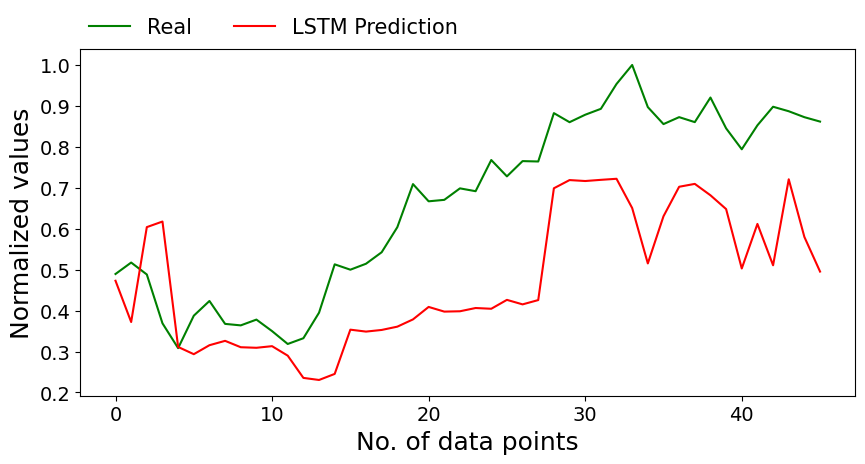

In [17]:
plt.figure(figsize=(10, 4.5))

plt.plot(y_test, label='Real', color='green')
plt.plot(y_pred_lstm_horizon_test, label='LSTM Prediction', color='red')

plt.xlabel('No. of data points', fontsize=18)
plt.ylabel('Normalized values', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2, 
           borderaxespad=0, frameon=False, prop={"size":15})
plt.show()

In [18]:
# Calculating Mean Square error for test dataset predictions
print("Test MSE:", mse(y_test, y_pred_lstm_horizon_test))

# Calculating Mean Square error for training dataset predictions
print("Train MSE:", mse(y_train, y_pred_lstm_horizon_train))

Test MSE: 0.10648623544658148
Train MSE: 0.10345788380823086
